# Basic Usage

## Prerequisites

The following code expects that Pillow is installed on your system.
Please execute the following commands to install it.

```
!conda install -c conda-forge pillow
```
or
```
!pip install pillow
!pip install numpy scipy scikit-image cupy-cuda110  # for cucim dependency (assuming that CUDA 11.0 is used for CuPy)
```

In [1]:
#!conda install -c conda-forge pillow

# or

# !pip install pillow
# !pip install numpy scipy scikit-image cupy-cuda110  # for cucim dependency (assuming that CUDA 11.0 is used for CuPy)

## Read image

In [2]:
from cucim import CuImage

img = CuImage("input/image.tif")

### See metadata

In [3]:
import json

print(img.is_loaded)                             # True if image data is loaded & available.
print(img.device)                                # A device type.
print(img.ndim)                                  # The number of dimensions.
print(img.dims)                                  # A string containing a list of dimensions being requested.
print(img.shape)                                 # A tuple of dimension sizes (in the order of `dims`).
print(img.size('XYC'))                           # Returns size as a tuple for the given dimension order.
print(img.dtype)                                 # The data type of the image.
print(img.channel_names)                         # A channel name list.
print(img.spacing())                             # Returns physical size in tuple.
print(img.spacing_units())                       # Units for each spacing element (size is same with `ndim`).
print(img.origin)                                # Physical location of (0, 0, 0) (size is always 3).
print(img.direction)                             # Direction cosines (size is always 3x3).
print(img.coord_sys)                             # Coordinate frame in which the direction cosines are measured. Available Coordinate frame is not finalized yet.
print(img.associated_images)                     # Returns a set of associated image names.
print(json.dumps(img.resolutions, indent=2))     # Returns a dict that includes resolution information.
print(json.dumps(img.metadata, indent=2))        # A metadata object as `dict`
print(img.raw_metadata)                          # A raw metadata string.

True
cpu
3
YXC
[26420, 19920, 3]
[19920, 26420, 3]
<cucim.DLDataType code:DLUInt(1) bits:8 lanes:1>
['R', 'G', 'B']
[1.0, 1.0, 1.0]
['micrometer', 'micrometer', 'color']
[0.0, 0.0, 0.0]
[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
LPS
set()
{
  "level_count": 7,
  "level_dimensions": [
    [
      19920,
      26420
    ],
    [
      9960,
      13210
    ],
    [
      4980,
      6605
    ],
    [
      2490,
      3302
    ],
    [
      1245,
      1651
    ],
    [
      622,
      826
    ],
    [
      311,
      413
    ]
  ],
  "level_downsamples": [
    1.0,
    2.0,
    4.0,
    8.000605583190918,
    16.001211166381836,
    32.00559616088867,
    64.01119232177734
  ],
  "level_tile_sizes": [
    [
      256,
      256
    ],
    [
      256,
      256
    ],
    [
      256,
      256
    ],
    [
      256,
      256
    ],
    [
      256,
      256
    ],
    [
      256,
      256
    ],
    [
      256,
      256
    ]
  ]
}
{
  "cucim": {
    "associated_imag

### Read region

Please keep in mind that values for `location` is based on level-0 resolution (the largest resolution).

In [4]:
# Read whole slide at the lowest resolution
resolutions = img.resolutions
level_dimensions = resolutions["level_dimensions"]
level_count = resolutions["level_count"]
region = img.read_region(location=[0,0], size=level_dimensions[level_count - 1], level=level_count - 1)

region.save("thumbnail.ppm")  # currently, cuCIM can save image with .ppm format.

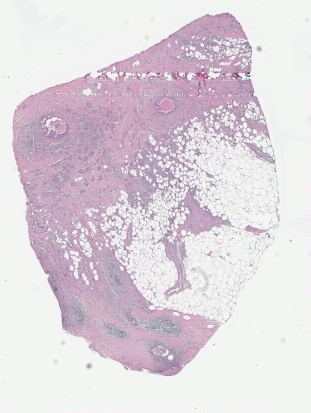

In [5]:
from PIL import Image
Image.open("thumbnail.ppm")

In [6]:
region = img.read_region([10000,10000], [512,512], 0)
region.save("test.ppm")

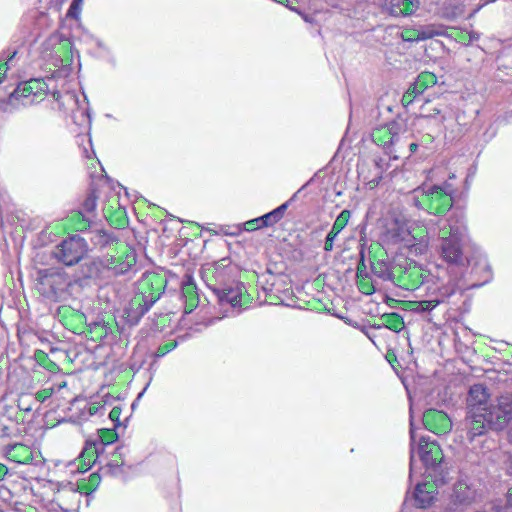

In [7]:
from PIL import Image
Image.open("test.ppm")

### `__array_interface__` support

In [8]:
import numpy as np
np_arr = np.array([1,2,3])
print(np_arr.__array_interface__)

{'data': (54300336, False), 'strides': None, 'descr': [('', '<i8')], 'typestr': '<i8', 'shape': (3,), 'version': 3}


As you can see from the above result, a NumPy array has `__array_interface__` property.

A Python object that has `__array_interface__` property is considered as a NumPy array and can be converted to a NumPy array through `np.asarray(obj)` method.

[\_\_array_interface__](https://numpy.org/doc/stable/reference/arrays.interface.html) is supported in CuImage object so the following code works to show the image in the Jupyter notebook.

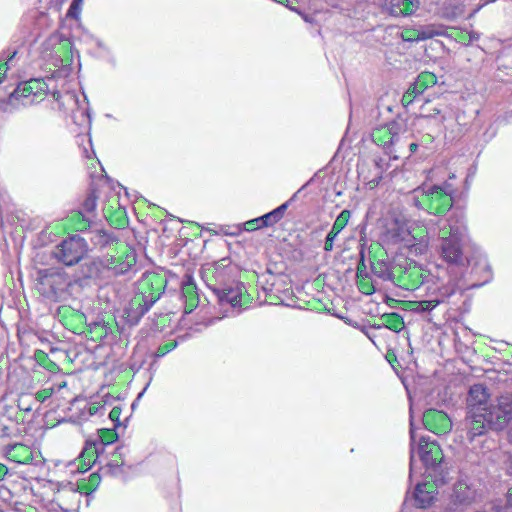

In [9]:
np_img_arr = np.asarray(region)
Image.fromarray(np_img_arr)

### `__cuda_array_interface__` support

In [10]:
import cupy as cp
cp_arr = cp.array([1,2,3])
print(cp_arr.__cuda_array_interface__)

{'shape': (3,), 'typestr': '<i8', 'descr': [('', '<i8')], 'stream': 1, 'version': 3, 'strides': None, 'data': (81888083968, False)}


A CuPy array has `__cuda_array_interface__` property.

A Python object that has `__cuda_array_interface__` property is considered as a CUDA array-like object and can be converted to CuPy array through `cp.asarray(obj)` method.

[\_\_cuda_array_interface__](https://numba.readthedocs.io/en/stable/cuda/cuda_array_interface.html) is also supported in CuImage object if the user specify `device='cuda'` in `read_region()` method.

The following code shows how to load image to GPU memory and visualize in the Jupyter notebook.

cuda
{'data': (81888084480, False), 'strides': None, 'descr': [('', '|u1')], 'typestr': '|u1', 'shape': (413, 311, 3), 'version': 3, 'mask': None, 'stream': 1}


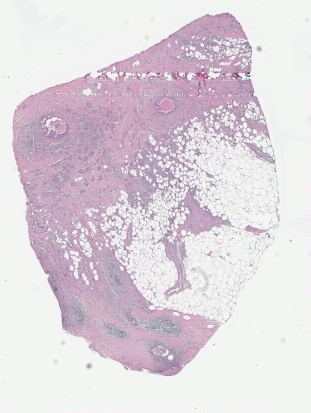

In [11]:
import cupy as cp
from cucim import CuImage

img = CuImage("input/image.tif")
resolutions = img.resolutions
level_dimensions = resolutions["level_dimensions"]
level_count = resolutions["level_count"]

region = img.read_region([0,0], level_dimensions[level_count - 1], level_count - 1, device="cuda")

print(region.device)
print(region.__cuda_array_interface__)

cupy_arr = cp.asarray(region)
Image.fromarray(cupy_arr.get())

### Associated images

Some image formats such as Philips TIFF and Aperio SVS have associated images (Macro or Label images) in addition to the multi-resolution images.

Let's assume that the image has only `macro` image.

```python
>>> img.associated_images
{'macro'}

>>> 'macro' in img.associated_images
True

>>> macro_image = img.associated_image('macro')
<cucim.CuImage path:>
```
You can see the macro image by using the following statements:

```python
>>> import numpy as np
>>> from PIL import Image
>>> np_img_arr = np.asarray(macro_image)
>>> Image.fromarray(np_img_arr)   
```

You can check if an associated image with a specific name (e.g., `label`) exists or not, like below:
```python
>>> img.associated_image('label')
<cucim.CuImage path:<null>>

>>> 'label' in img.associated_images
False

>>> if not img.associated_image('label'):
>>>     print("There is no associated image named 'label'!")
There is no associated image named 'label'!
```